In [21]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

from scipy.stats import norm

import pickle

In [ ]:
## trends comparisons

In [4]:
nfit = 789
nval = 9
pred_int = 70
nmod = 16

In [5]:
### load predictions
nngp = np.load('./tas_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./tas_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./tas_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

# nngp = np.array(nngp)
# lm = np.array(lm)
# ens = np.array(ens)

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)


# aggregate by year
nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])

del nngp, lm, ens

xrcp = pickle.load(open('../data/saved/xrcp_tas.pkl', 'rb'))
mm_yr = []
for m in range(nmod):
    xt = xrcp[m][nval:]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, xt.shape[1]))
    scale /= np.mean(scale)
    xt_yr = np.array([np.mean(xt[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
    
    mm_yr.append(xt_yr) 
mm_yr = np.stack(mm_yr, axis = 1)


### load observations and center
tas_mean = np.load('../data/saved/t2m_obs.npy')

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)

obs = tas_mean[nfit:(nfit + pred_int)]
obs = np.array([np.mean(obs[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(6)])
tas_mean = np.mean(tas_mean * scale[None,:,None])

tas_nngp = nngp_yr - tas_mean
tas_lm = lm_yr - tas_mean
tas_ens = ens_yr - tas_mean
tas_mm = mm_yr - tas_mean
tas = obs - tas_mean

In [6]:
### load predictions
nngp = np.load('./pr_predictions/nngp_pred.npy', mmap_mode = 'r')
lm = np.load('./pr_predictions/lm_pred.npy', mmap_mode = 'r')[nval:]
ens = np.load('./pr_predictions/ens_pred.npy', mmap_mode = 'r')[nval:]

# nngp = np.array(nngp)
# lm = np.array(lm)
# ens = np.array(ens)

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)


# aggregate by year
nngp_yr = np.array([np.mean(nngp[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
lm_yr = np.array([np.mean(lm[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
ens_yr = np.array([np.mean(ens[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])

del nngp, lm, ens

xrcp = pickle.load(open('../data/saved/xrcp_pr.pkl', 'rb'))
mm_yr = []
for m in range(nmod):
    xt = xrcp[m][nval:]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, xt.shape[1]))
    scale /= np.mean(scale)
    xt_yr = np.array([np.mean(xt[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(85)])
    
    mm_yr.append(xt_yr) 
mm_yr = np.stack(mm_yr, axis = 1)


### load observations and center
pr_mean = np.load('../data/saved/pr_obs.npz.npy')

scale = np.cos(np.linspace(math.pi/2, -math.pi/2, 721))
scale /= np.mean(scale)

obs = pr_mean[nfit:(nfit + pred_int)]
obs = np.array([np.mean(obs[(i*12):((i+1)*12)] * scale[None,:,None]) for i in range(6)])
pr_mean = np.mean(pr_mean * scale[None,:,None])

pr_nngp = nngp_yr - pr_mean
pr_lm = lm_yr - pr_mean
pr_ens = ens_yr - pr_mean
pr_mm = mm_yr - pr_mean
pr = obs - pr_mean

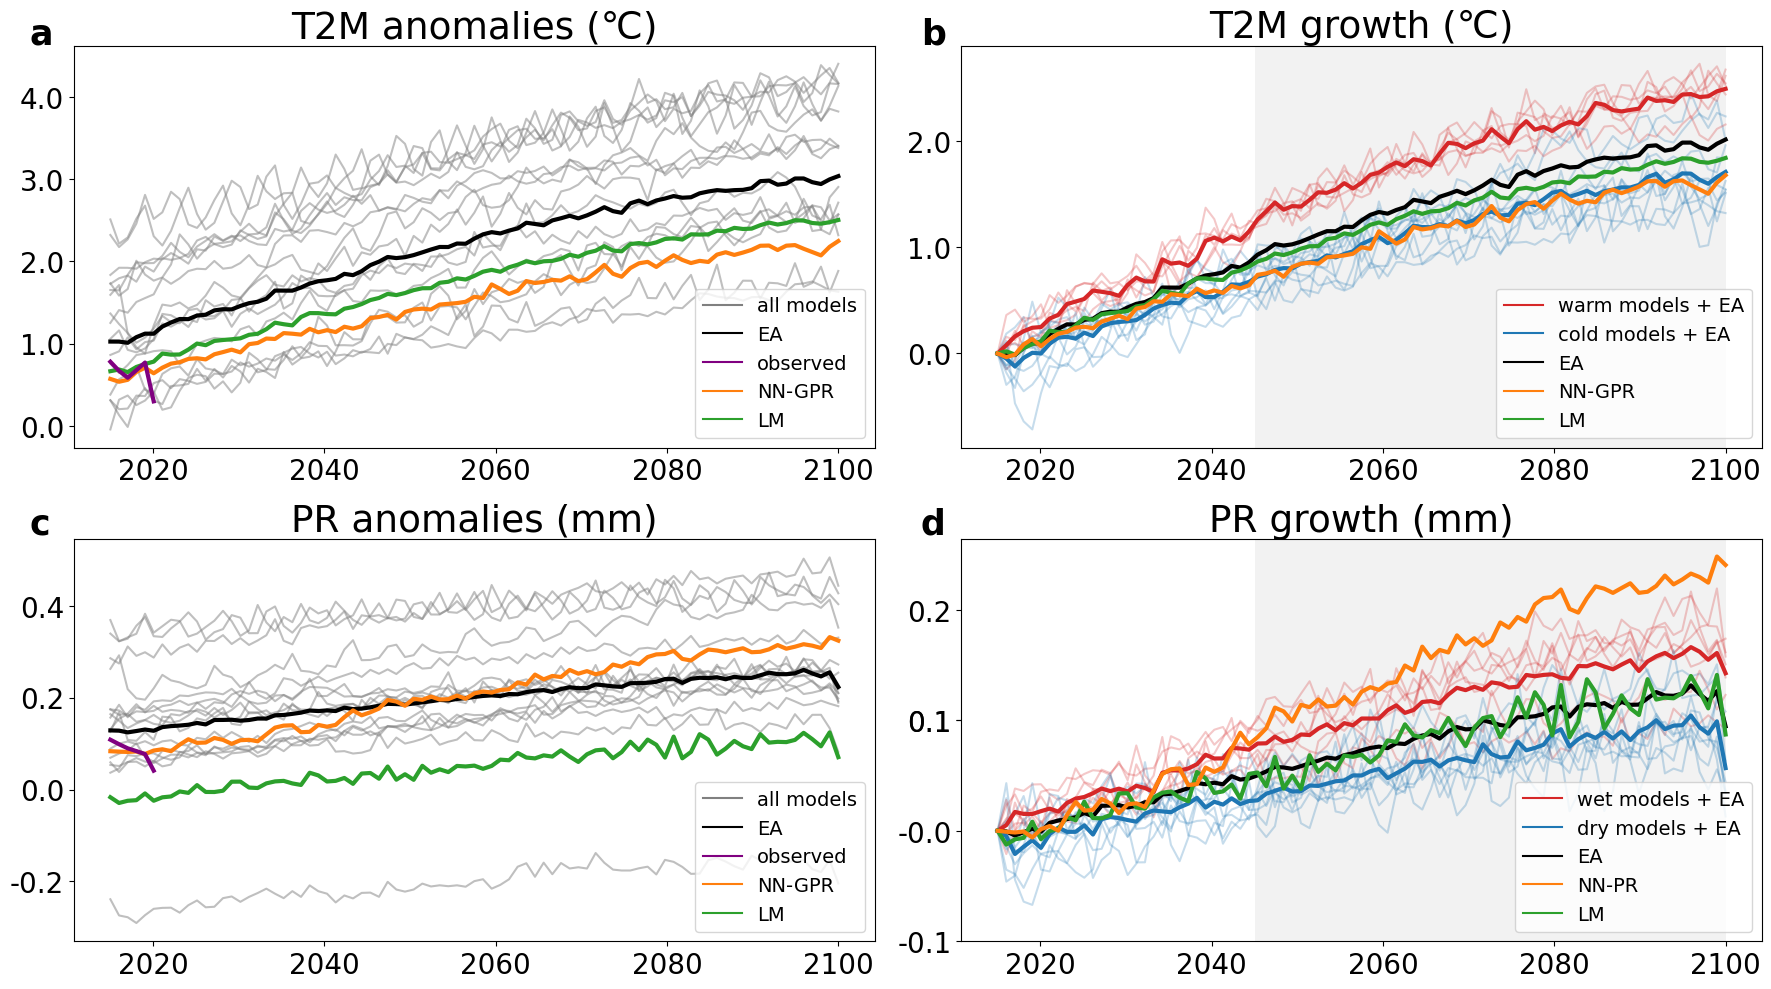

In [9]:
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (18, 10))
ax = ax.reshape(-1)

plt.rc('ytick', labelsize = 20)
plt.rc('xtick', labelsize = 20)


s = np.linspace(2015, 2100, 85)

#### TAS
cold_avg0 = 0
cold_avg1 = 0
warm_avg0 = 0
warm_avg1 = 0
ens_avg = 0

### plotting
n = 0
m = 0
for i in range(tas_mm.shape[1]):
    if (tas_mm[:,i] - tas_mm[0,i])[30] > 1.1:
        ax[0].plot(s, tas_mm[:,i], c = 'grey', alpha = 0.5)
        ax[1].plot(s, tas_mm[:,i] - tas_mm[0,i], c = 'C3', alpha = 0.25)
        
        m = m + 1
        warm_avg0 += tas_mm[:,i]
        warm_avg1 += tas_mm[:,i] - tas_mm[0,i]
    else:
        n = n + 1
        cold_avg0 += tas_mm[:,i]
        cold_avg1 += tas_mm[:,i] - tas_mm[0,i]
        
        ax[0].plot(s, tas_mm[:,i], c = 'grey', alpha = 0.5)
        ax[1].plot(s, tas_mm[:,i] - tas_mm[0,i], c = 'C0', alpha = 0.25)
        
ax[0].plot(s, tas_ens, c = 'black', linewidth = 3)
ax[0].plot(s, tas_lm, c = 'C2', linewidth = 3)
ax[0].plot(s, tas_nngp, c = 'C1', linewidth = 3)
ax[0].plot(s[0:6], tas, c = 'purple', linewidth = 3)
ax[0].set_title('T2M anomalies (\u2103)', fontsize = 27)

ax[1].plot(s, tas_ens - tas_ens[0], c = 'black', linewidth = 3)
ax[1].plot(s, warm_avg1/m, c = 'C3', linewidth = 3)
ax[1].plot(s, cold_avg1/n, c = 'C0', linewidth = 3)
ax[1].plot(s, tas_lm - tas_lm[0], c = 'C2', linewidth = 3)
ax[1].plot(s, tas_nngp - tas_nngp[0], c = 'C1', linewidth = 3)
ax[1].set_title('T2M growth (\u2103)', fontsize = 27)
ax[1].axvspan(2045, 2100, facecolor='grey', alpha=0.10)


### legend
ax[0].plot([],[], c='grey', label = 'all models')
ax[0].plot([],[], c='black', label = 'EA')
ax[0].plot([],[], c='purple', label = 'observed')
ax[0].plot([],[], c='C1', label = 'NN-GPR')
ax[0].plot([],[], c='C2', label = 'LM')
ax[0].legend(fontsize = 14, loc = 'lower right')

ax[1].plot([],[], c='C3', label = 'warm models + EA')
ax[1].plot([],[], c='C0', label = 'cold models + EA')
ax[1].plot([],[], c='black', label = 'EA')
ax[1].plot([],[], c='C1', label = 'NN-GPR')
ax[1].plot([],[], c='C2', label = 'LM')
ax[1].legend(fontsize = 14, loc = 'lower right')


# ### labels
custom_ticks = np.linspace(2020, 2100, 5, dtype=int)
ax[0].set_xticks(custom_ticks)
ax[0].set_xticklabels(custom_ticks)
# ax[0].set_ylabel('T2M anomalies (\u2103)', fontsize = 20)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].set_xticks(custom_ticks)
ax[1].set_xticklabels(custom_ticks)
# ax[1].set_ylabel('T2M growth (\u2103)', fontsize = 20)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[0].text(0.035, 0.94, 'a', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
ax[1].text(0.53, 0.94, 'b', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)


## PR
cold_avg0 = 0
cold_avg1 = 0
warm_avg0 = 0
warm_avg1 = 0
ens_avg = 0

### plotting
n = 0
m = 0
for i in range(pr_mm.shape[1]):
    if (pr_mm[:,i] - pr_mm[0,i])[30] > 0.05:
        ax[2].plot(s, pr_mm[:,i], c = 'grey', alpha = 0.5)
        ax[3].plot(s, pr_mm[:,i] - pr_mm[0,i], c = 'C3', alpha = 0.25)
        
        m = m + 1
        warm_avg0 += pr_mm[:,i]
        warm_avg1 += pr_mm[:,i] - pr_mm[0,i]
    else:
        n = n + 1
        cold_avg0 += pr_mm[:,i]
        cold_avg1 += pr_mm[:,i] - pr_mm[0,i]
        
        ax[2].plot(s, pr_mm[:,i], c = 'grey', alpha = 0.5)
        ax[3].plot(s, pr_mm[:,i] - pr_mm[0,i], c = 'C0', alpha = 0.25)
        
ax[2].plot(s, pr_ens, c = 'black', linewidth = 3)
ax[2].plot(s, pr_lm, c = 'C2', linewidth = 3)
ax[2].plot(s, pr_nngp, c = 'C1', linewidth = 3)
ax[2].plot(s[0:6], pr, c = 'purple', linewidth = 3)
ax[2].set_title('PR anomalies (mm)', fontsize = 27)

ax[3].plot(s, pr_ens - pr_ens[0], c = 'black', linewidth = 3)
ax[3].plot(s, warm_avg1/m, c = 'C3', linewidth = 3)
ax[3].plot(s, cold_avg1/n, c = 'C0', linewidth = 3)
ax[3].plot(s, pr_lm - pr_lm[0], c = 'C2', linewidth = 3)
ax[3].plot(s, pr_nngp - pr_nngp[0], c = 'C1', linewidth = 3)
ax[3].set_title('PR growth (mm)', fontsize = 27)
ax[3].axvspan(2045, 2100, facecolor='grey', alpha=0.10)


### legend
ax[2].plot([],[], c='grey', label = 'all models')
ax[2].plot([],[], c='black', label = 'EA')
ax[2].plot([],[], c='purple', label = 'observed')
ax[2].plot([],[], c='C1', label = 'NN-GPR')
ax[2].plot([],[], c='C2', label = 'LM')
ax[2].legend(fontsize = 14, loc = 'lower right')

ax[3].plot([],[], c='C3', label = 'wet models + EA')
ax[3].plot([],[], c='C0', label = 'dry models + EA')
ax[3].plot([],[], c='black', label = 'EA')
ax[3].plot([],[], c='C1', label = 'NN-PR')
ax[3].plot([],[], c='C2', label = 'LM')
ax[3].legend(fontsize = 14, loc = 'lower right')


# ### labels
custom_ticks = np.linspace(2020, 2100, 5, dtype=int)
ax[2].set_xticks(custom_ticks)
ax[2].set_xticklabels(custom_ticks)
ax[2].tick_params(axis='both', which='major', labelsize = 20)
# ax[2].set_ylabel('PR anomalies (mm/day)', fontsize = 20)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[3].set_xticks(custom_ticks)
ax[3].set_xticklabels(custom_ticks)
ax[2].tick_params(axis='both', which='major', labelsize = 20)
# ax[3].set_ylabel('PR growth (mm/day)', fontsize = 20)
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


custom_ticks = np.round(np.linspace(-0.1, 0.2, 5), 1)
ax[3].set_yticks(custom_ticks)
ax[3].set_yticklabels(custom_ticks)

ax[2].text(0.035, 0.45, 'c', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
ax[3].text(0.53, 0.45, 'd', fontsize=25, fontweight='bold', transform=plt.gcf().transFigure)
   
plt.show()

In [8]:
print(np.round(np.mean(tas_nngp - tas_ens), 2))
print(np.round(np.mean(tas_lm - tas_ens), 2))

-0.67
-0.44


In [23]:
print(np.round(np.mean(pr_nngp - pr_ens), 2))
print(np.round(np.mean(pr_lm - pr_ens), 2))

0.01
-0.15


In [30]:
print(np.round(tas_nngp[-1] - tas_nngp[0], 2))
print(np.round(tas_ens[-1] - tas_ens[0], 2))

1.68
2.01
